# LKJ Cholesky Covariance Priors for Multivariate Normal Models

To illustrate modelling covariance with the LKJ distribution, we first generate a two-dimensional normally-distributed sample data set.

In [2]:
%env MKL_THREADING_LAYER=GNU
import arviz as az
import numpy as np
import pymc as pm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

print(f"Running on PyMC v{pm.__version__}")

env: MKL_THREADING_LAYER=GNU
Running on PyMC v5.5.0


In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
N = 10000

mu_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Sigma_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = rng.multivariate_normal(mu_actual, Sigma_actual, size=N)
Sigma_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

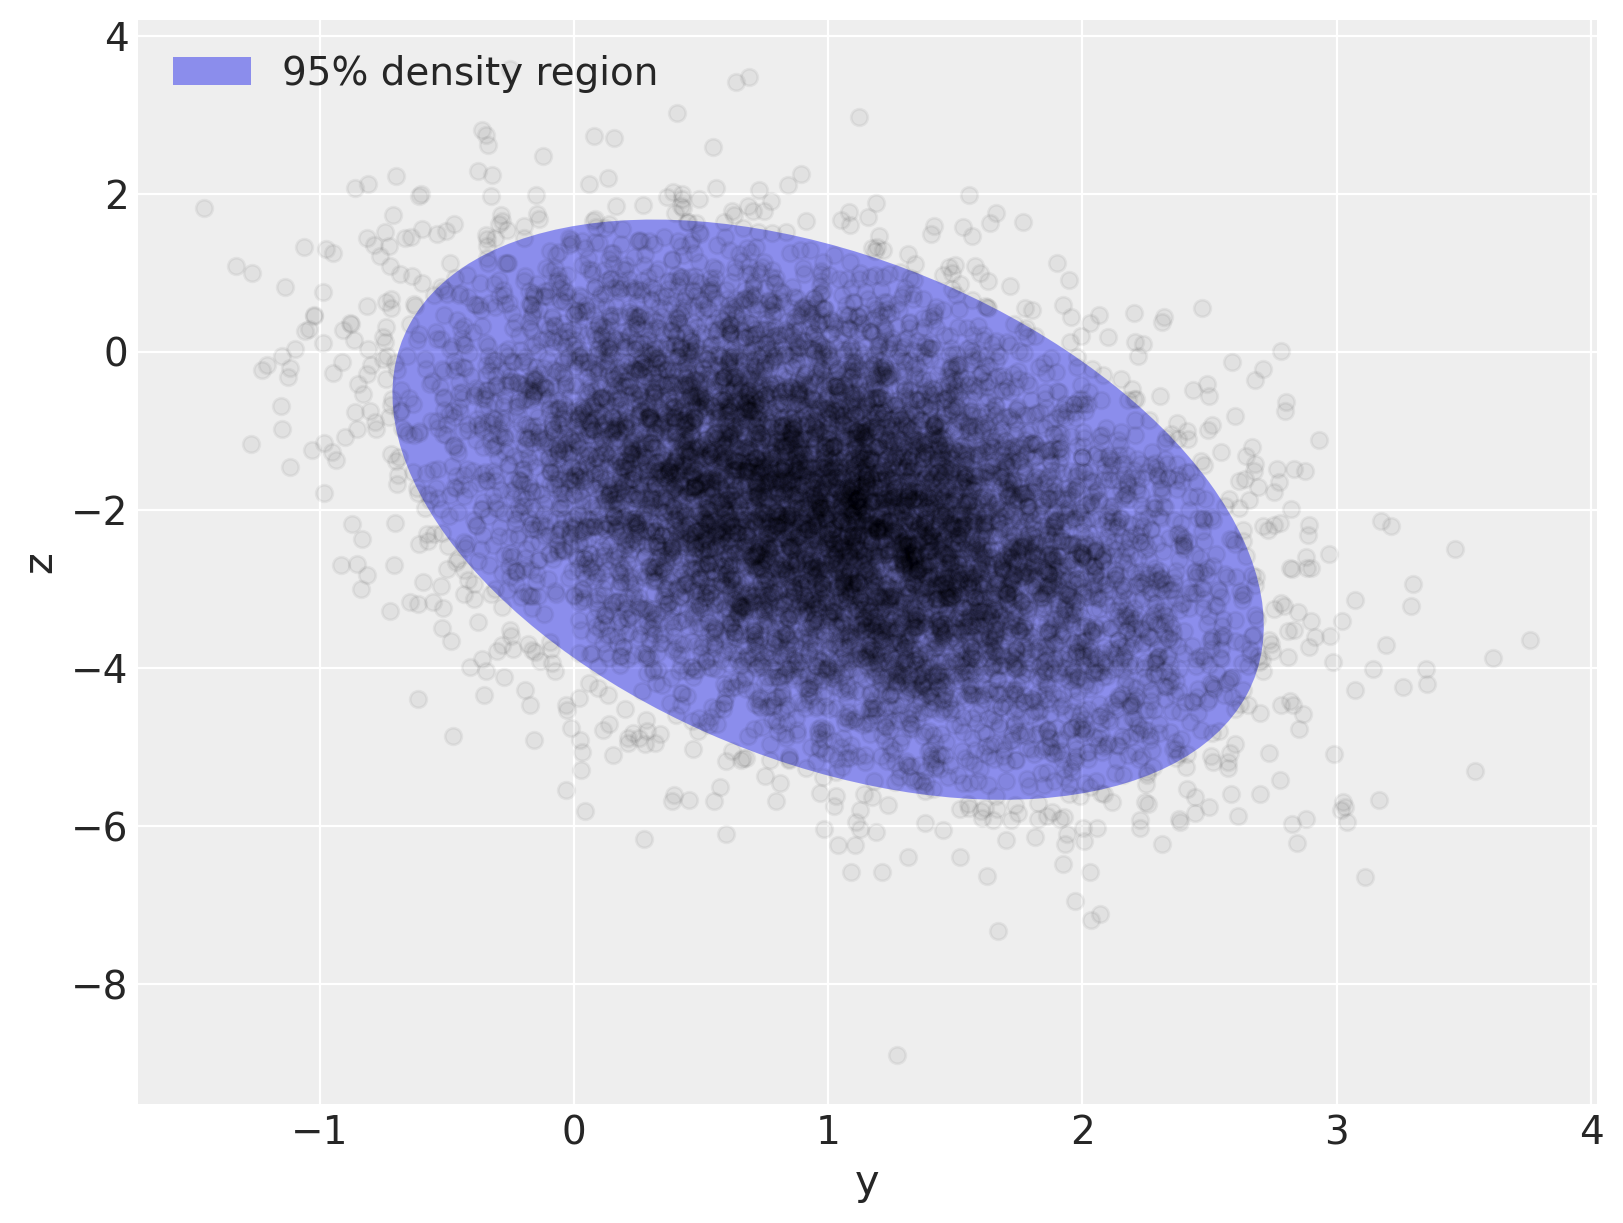

In [5]:
var, U = np.linalg.eig(Sigma_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor("C0")
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)
ax.set_xlabel("y")
ax.set_ylabel("z")

rect = plt.Rectangle((0, 0), 1, 1, fc="C0", alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

In [7]:
coords = {"axis": ["y", "z"], "axis_bis": ["y", "z"], "obs_id": np.arange(N)}
# with pm.Model(coords=coords, rng_seeder=RANDOM_SEED) as model:
with pm.Model(coords=coords) as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2)
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("axis", "axis_bis"))
cov

cov ~ Deterministic(f(chol))

To complete our model, we place independent, weakly regularizing priors, $N$(0,1.5) on $\mu$

In [6]:
with model:
    mu = pm.Normal("mu", 0.0, sigma=1.5, dims="axis")
    obs = pm.MvNormal("obs", mu, chol=chol, observed=x, dims=("obs_id", "axis"))

We sample from this model using NUTS and give the trace to ArviZ for summarization

In [8]:
with model:
    trace = pm.sample(chains=4, 
        idata_kwargs={"dims": {"chol_stds": ["axis"], "chol_corr": ["axis", "axis_bis"]}},
    )
az.summary(trace, var_names="~chol", round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\wwl\.conda\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_corr[y, y]",1.00,0.00,1.00,1.00,0.00,0.00,4000.00,4000.00,NaN
"chol_corr[y, z]",0.01,0.45,-0.79,0.79,0.01,0.01,1248.38,2230.33,1.01
"chol_corr[z, y]",0.01,0.45,-0.79,0.79,0.01,0.01,1248.38,2230.33,1.01
"chol_corr[z, z]",1.00,0.00,1.00,1.00,0.00,0.00,167.98,121.12,1.02
chol_stds[y],1.04,0.98,0.00,2.84,0.03,0.02,941.54,1073.14,1.01
chol_stds[z],1.08,1.07,0.04,2.95,0.05,0.04,68.75,14.25,1.05
"cov[y, y]",2.05,4.32,0.00,8.09,0.12,0.09,941.54,1073.14,1.01
"cov[y, z]",0.02,0.98,-1.32,1.61,0.03,0.02,1520.82,1463.17,1.01
"cov[z, y]",0.02,0.98,-1.32,1.61,0.03,0.02,1520.82,1463.17,1.01
"cov[z, z]",2.31,5.65,0.00,8.69,0.20,0.14,68.75,14.25,1.05


Sampling went smoothly: no divergences and good r-hats (except for the diagonal elements of the correlation matrix - however, these are not a concern, because, they should be equal to 1 for each sample for each chain and the variance of a constant value isn’t defined. If one of the diagonal elements has r_hat defined, it’s likely due to tiny numerical errors).

You can also see that the sampler recovered the true means, correlations and standard deviations. As often, that will be clearer in a graph:

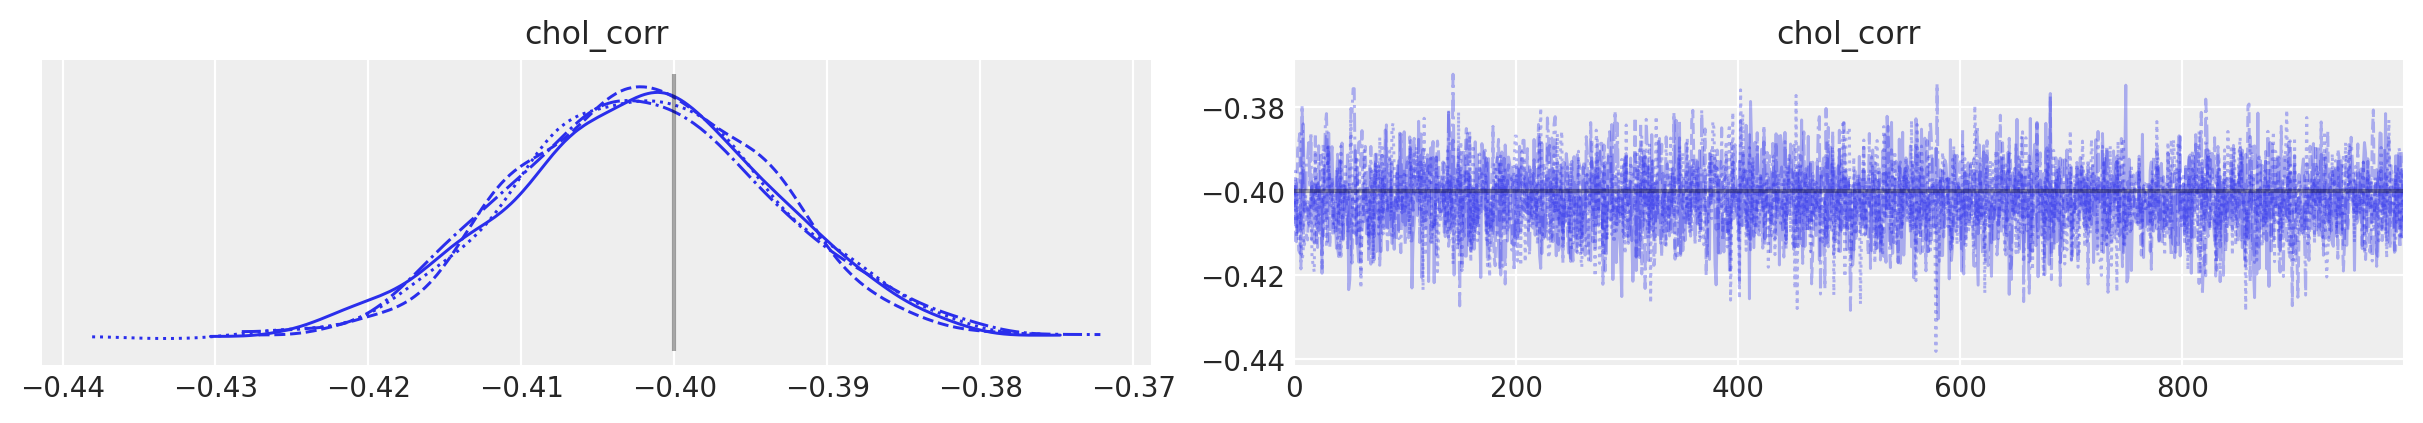

In [8]:
az.plot_trace(
    trace,
    var_names="chol_corr",
    coords={"axis": "y", "axis_bis": "z"},
    lines=[("chol_corr", {}, Rho_actual[0, 1])],
);

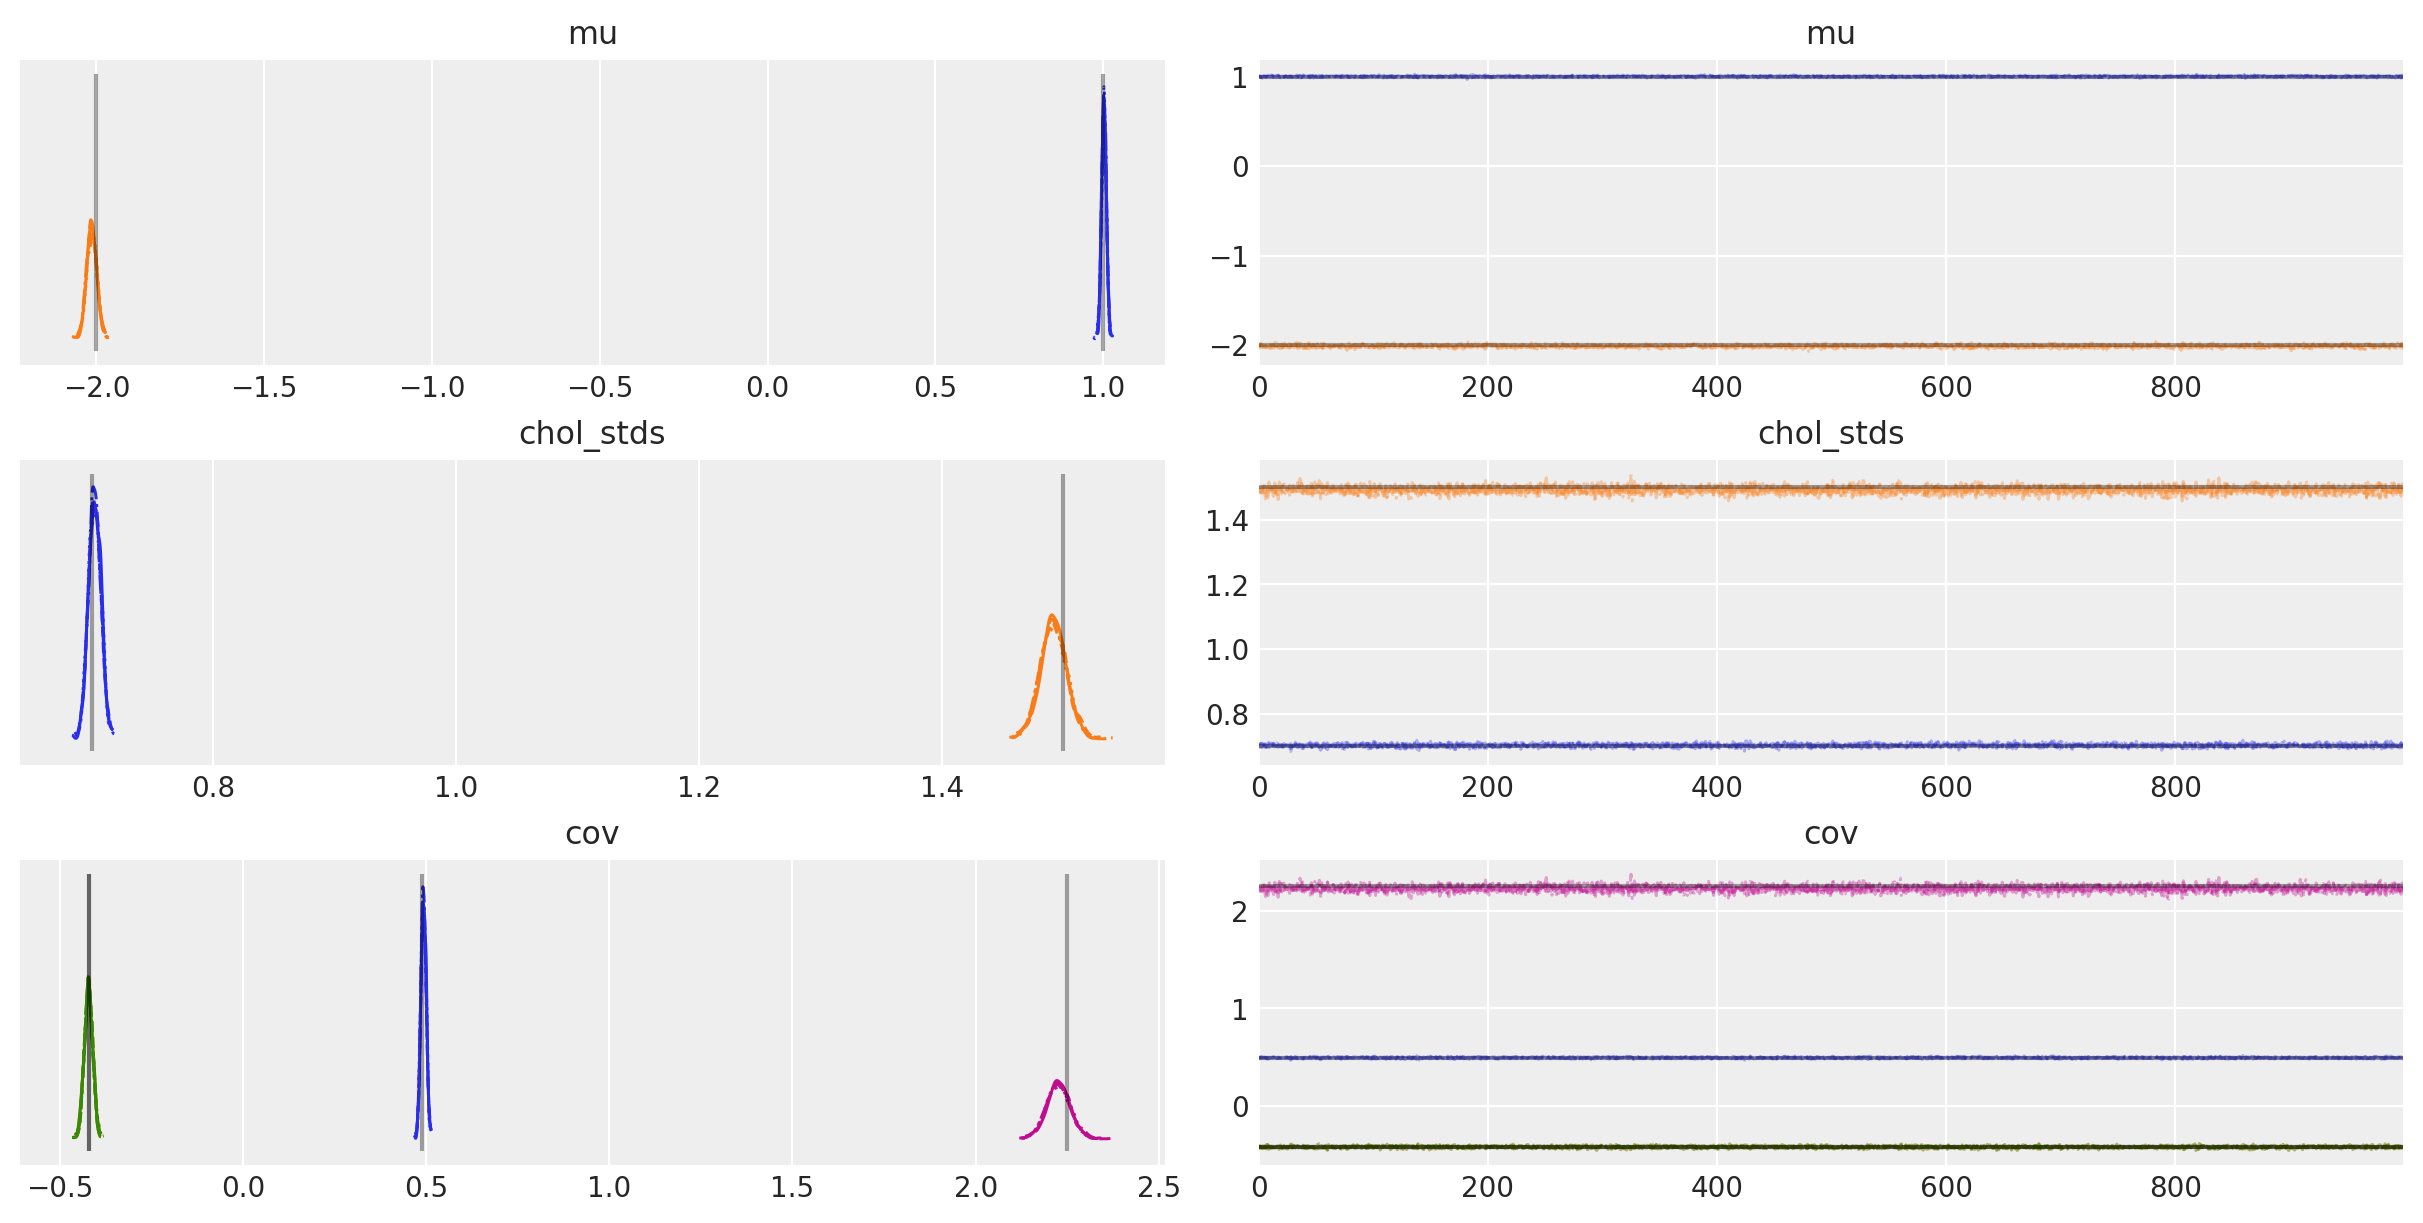

In [9]:
az.plot_trace(
    trace,
    var_names=["~chol", "~chol_corr"],
    compact=True,
    lines=[
        ("mu", {}, mu_actual),
        ("cov", {}, Sigma_actual),
        ("chol_stds", {}, sigmas_actual),
    ],
);

The posterior expected values are very close to the true value of each component! How close exactly? Let’s compute the percentage of closeness of $\mu$ and $\Sigma$

In [10]:
mu_post = trace.posterior["mu"].mean(("chain", "draw")).values
(1 - mu_post / mu_actual).round(2)

array([-0.  , -0.01])

In [11]:
Sigma_post = trace.posterior["cov"].mean(("chain", "draw")).values
(1 - Sigma_post / Sigma_actual).round(2)

array([[-0.01, -0.  ],
       [-0.  ,  0.01]])

So the posterior means are within 3% of the true values of $\mu$ and $\Sigma$.

Now let’s replicate the plot we did at the beginning, but let’s overlay the posterior distribution on top of the true distribution – you’ll see there is excellent visual agreement between both:

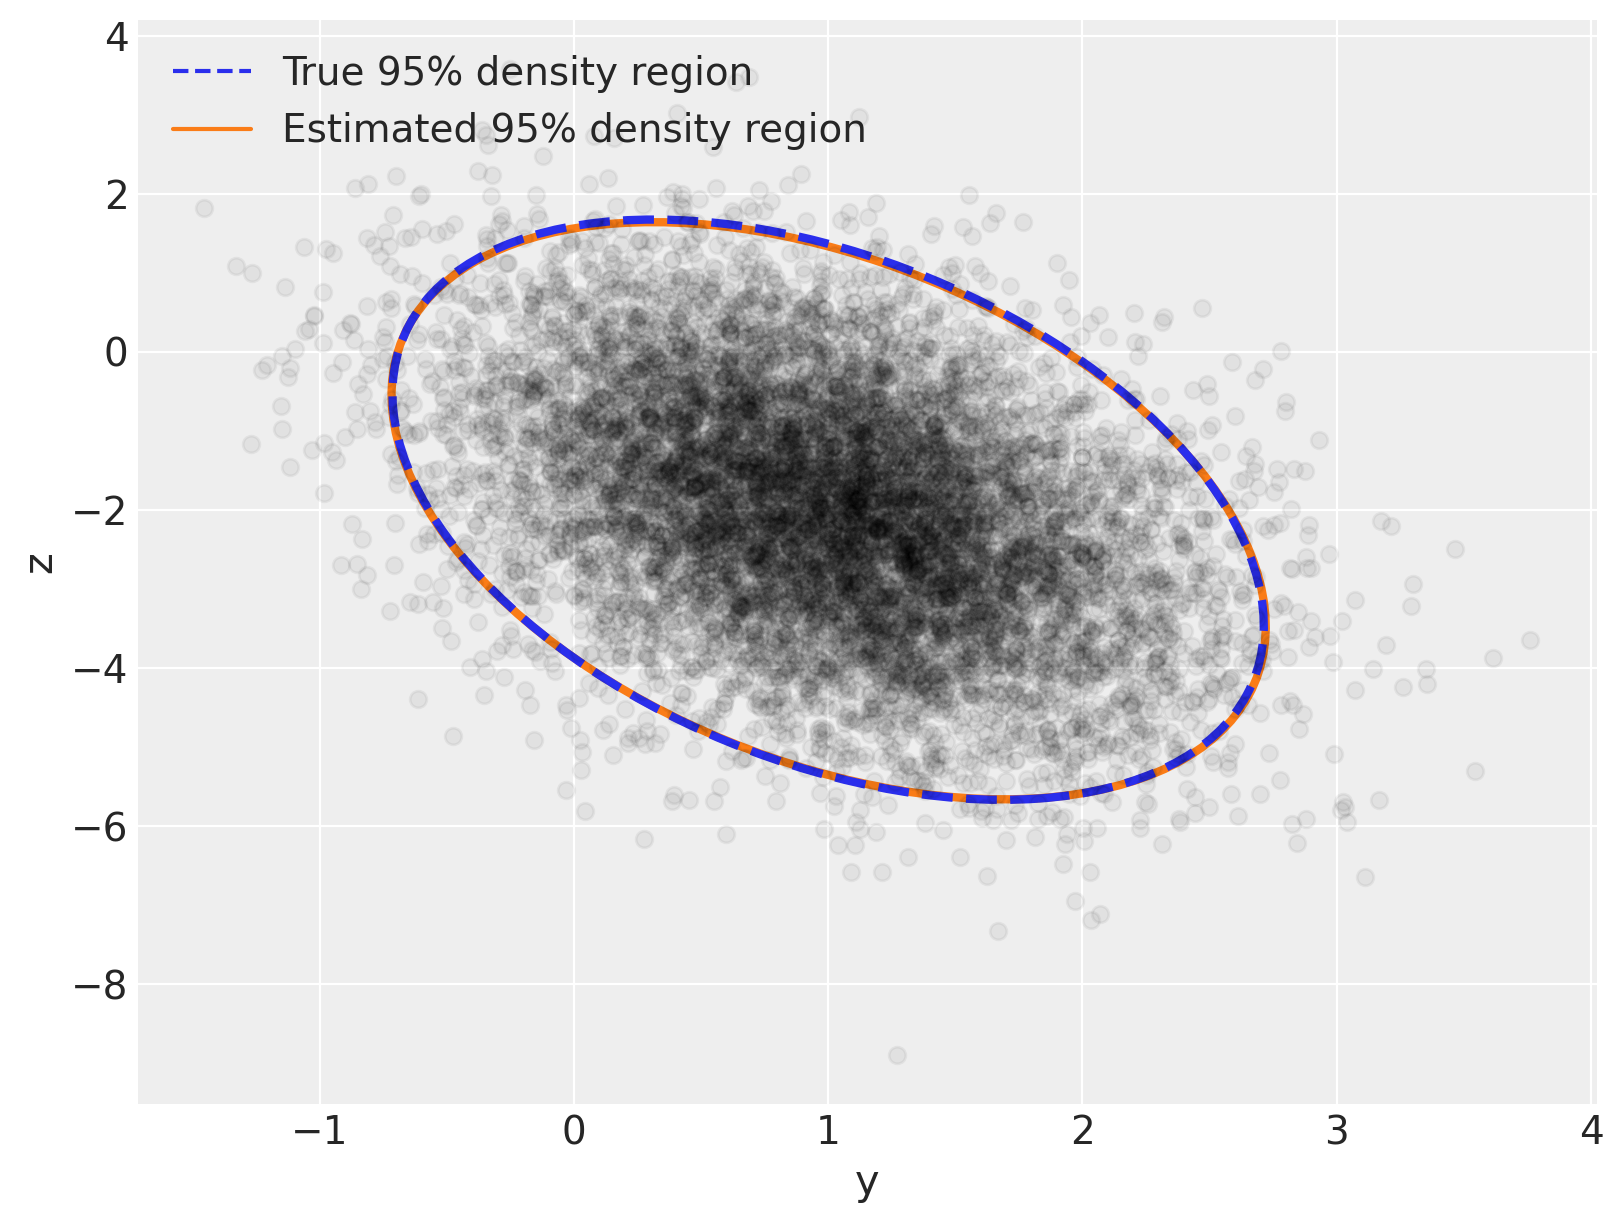

In [12]:
var_post, U_post = np.linalg.eig(Sigma_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(
    mu_actual,
    2 * np.sqrt(5.991 * var[0]),
    2 * np.sqrt(5.991 * var[1]),
    angle=angle,
    linewidth=3,
    linestyle="dashed",
)
e.set_edgecolor("C0")
e.set_zorder(11)
e.set_fill(False)
ax.add_artist(e)

e_post = Ellipse(
    mu_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
    linewidth=3,
)
e_post.set_edgecolor("C1")
e_post.set_zorder(10)
e_post.set_fill(False)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)
ax.set_xlabel("y")
ax.set_ylabel("z")

line = Line2D([], [], color="C0", linestyle="dashed", label="True 95% density region")
line_post = Line2D([], [], color="C1", label="Estimated 95% density region")
ax.legend(
    handles=[line, line_post],
    loc=2,
);

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

ModuleNotFoundError: No module named 'watermark'